# Import

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from IPython import display
import torch.backends.cudnn as cudnn
import random
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Data

In [6]:
def one_hot(label, num_classes):
    one_hot = np.zeros((len(label), num_classes))
    one_hot[np.arange(len(label)), label] = 1
    return one_hot

In [7]:
d_path = './'

dataframe_train = pd.read_csv(d_path + 'mitbih_train.csv', header=None)
dataframe_test = pd.read_csv(d_path + 'mitbih_test.csv', header=None)

n = len(dataframe_test.columns)
num_classes = 5

columns_name = ['col_' + str(i) for i in range(n)]
dataframe_train = dataframe_train.set_axis(columns_name, axis=1)
dataframe_test = dataframe_test.set_axis(columns_name, axis=1)

data_train = np.float32(dataframe_train.iloc[:, :-1])
labels_train = np.int32(dataframe_train.iloc[:, -1].to_numpy())

data_test = np.float32(dataframe_test.iloc[:, :-1].to_numpy())
labels_test = np.int32(dataframe_test.iloc[:, -1].to_numpy())

In [8]:
train_unique_elements, train_counts = np.unique(labels_train, return_counts=True)

print("Train set:")
for element, count in zip(train_unique_elements, train_counts):
    print(f"    Label {element} appears {count} times.")

Train set:
    Label 0 appears 72471 times.
    Label 1 appears 2223 times.
    Label 2 appears 5788 times.
    Label 3 appears 641 times.
    Label 4 appears 6431 times.


In [9]:
test_unique_elements, test_counts = np.unique(labels_test, return_counts=True)

print("Test set:")
for element, count in zip(test_unique_elements, test_counts):
    print(f"    Label {element} appears {count} times.")

Test set:
    Label 0 appears 18118 times.
    Label 1 appears 556 times.
    Label 2 appears 1448 times.
    Label 3 appears 162 times.
    Label 4 appears 1608 times.


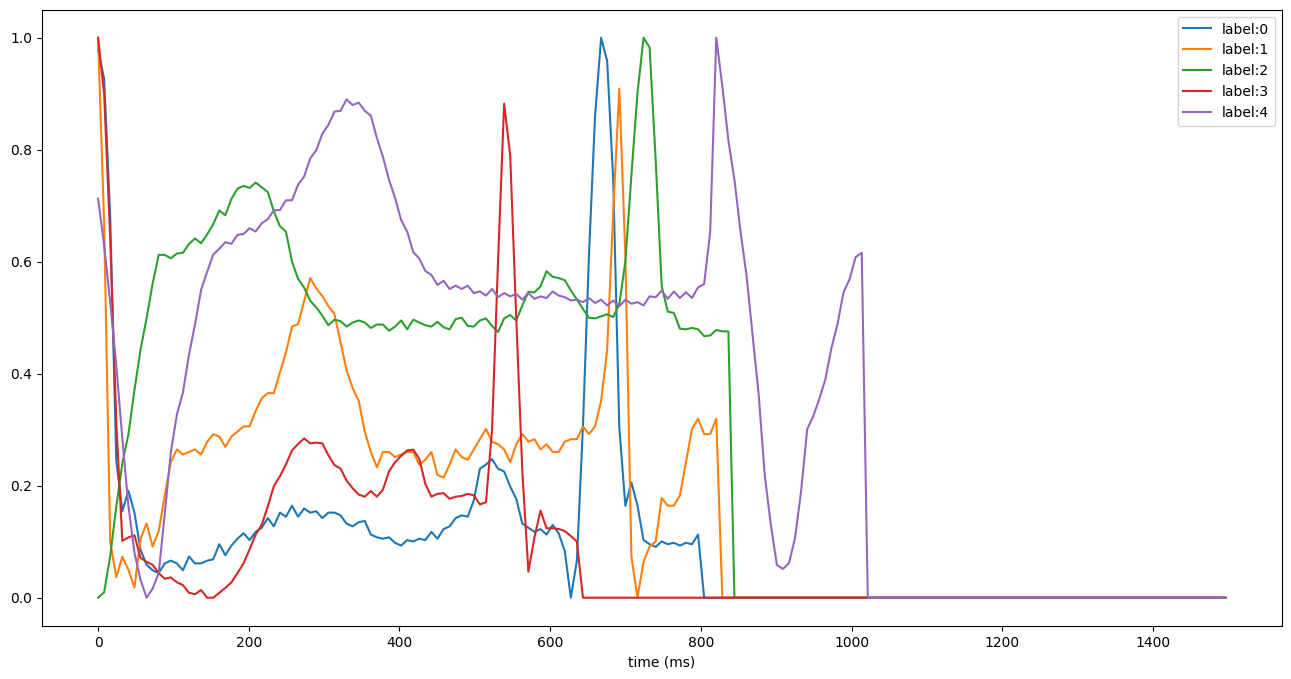

In [10]:
t = np.linspace (0,(187/125)*1000, 187)
plt.figure(figsize=(16,8))

plt.plot (t,data_train[labels_train == 0][0] , label = f"label:{labels_train[labels_train == 0][0]}")
plt.plot (t,data_train[labels_train == 1][0] , label = f"label:{labels_train[labels_train == 1][0]}")
plt.plot (t,data_train[labels_train == 2][0] , label = f"label:{labels_train[labels_train == 2][0]}")
plt.plot (t,data_train[labels_train == 3][0] , label = f"label:{labels_train[labels_train == 3][0]}")
plt.plot (t,data_train[labels_train == 4][0] , label = f"label:{labels_train[labels_train == 4][0]}")
plt.legend()
plt.xlabel("time (ms)")
plt.show()

## Selecting and Spliting Data

In [11]:
seed = np.random.randint(0, 10000)

"""
    Train and Validation
"""
train_unique_elements, train_counts = np.unique(labels_train, return_counts=True)
select_num = np.min(train_counts)

df_list = []

for i in train_unique_elements:
    df_list.append(dataframe_train[labels_train == i].sample(n=select_num, random_state=seed))

df = pd.concat(df_list).sample(frac=1)
train_selected_df, val_selected_df = train_test_split(df, test_size=0.2)


data_train_selected = np.float32(train_selected_df.iloc[:, :-1])
labels_train_selected = np.int32(train_selected_df.iloc[:, -1].to_numpy())
one_hot_labels_train_selected = one_hot(labels_train_selected, num_classes)

data_val_selected = np.float32(val_selected_df.iloc[:, :-1])
labels_val_selected = np.int32(val_selected_df.iloc[:, -1].to_numpy())
one_hot_labels_val_selected = one_hot(labels_val_selected, num_classes)



"""
    Test
"""
test_unique_elements, test_counts = np.unique(labels_test, return_counts=True)
select_num = np.min(test_counts)
df_list = []

for i in test_unique_elements:
    df_list.append(dataframe_test[labels_test == i].sample(n=select_num, random_state=seed))

test_selected_df = pd.concat(df_list)
data_test_selected = np.float32(test_selected_df.iloc[:, :-1])
labels_test_selected = np.int32(test_selected_df.iloc[:, -1].to_numpy())
one_hot_labels_test_selected = one_hot(labels_test_selected, num_classes)

## DataLoader

In [12]:
class HeartbeatDataset(Dataset):
    
    def __init__(self, data, labels, input_size = 1):
        self.n_samples = data.shape[0]
        self.input_size = input_size
        self.data = torch.from_numpy(data).to(dtype=torch.float32)
        self.labels = torch.from_numpy(labels).to(dtype=torch.float32)

    def __getitem__(self, index):

        if self.input_size == 1:
            return self.data[index].unsqueeze(1), self.labels[index]

        else:
            data_array = []
            for i in range(self.data.shape[1] - self.input_size):
                data_array.append(self.data[index][i:i + self.input_size])

            data_array = torch.stack(data_array)           
            return data_array, self.labels[index]

    def __len__(self):
        return self.n_samples


In [13]:
batch_size = 64
input_size = 1

train_set = HeartbeatDataset(data_train_selected, one_hot_labels_train_selected)
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)

test_set = HeartbeatDataset(data_test_selected, one_hot_labels_test_selected)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                         shuffle=True)

val_set = HeartbeatDataset(data_val_selected, one_hot_labels_val_selected)
val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=True)


# Design Model

In [14]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers , batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, h = self.rnn(x, h0)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [15]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, hidden_size)
        self.fc_2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).requires_grad_()
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc_1(out[:, -1, :])
        out = self.fc_2(out)
        return out

# Train

In [16]:
model = SimpleLSTM(input_size, 10, 2, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 100
train_loss_array = []
val_loss_array = []

for e in range(1, epochs+1):    

    # train
    train_epoch_loss = 0.0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        label_pred = model(data)
        loss = criterion(label_pred, label)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

    train_loss_array.append(train_epoch_loss / len(train_loader))
    
    # validation
    val_epoch_loss = 0.0
    for data, label in val_loader:
        data, label = data.to(device), label.to(device)
        
        label_pred = model(data)
        loss = criterion(label_pred, label)
        val_epoch_loss += loss.item()
    
    val_loss_array.append(val_epoch_loss / len(val_loader))

    if e % int(epochs/10) == 0:
        print(f'Epoch [{e}/{epochs}], Train Loss: {train_loss_array[-1]:.4f}, Validation Loss: {val_loss_array[-1]:.4f}')


torch.cuda.empty_cache()

Epoch [10/100], Train Loss: 1.6104, Validation Loss: 1.6061
Epoch [20/100], Train Loss: 1.4405, Validation Loss: 1.3142
Epoch [30/100], Train Loss: 1.2050, Validation Loss: 1.1157
Epoch [40/100], Train Loss: 1.1795, Validation Loss: 1.1679
Epoch [50/100], Train Loss: 1.1251, Validation Loss: 1.2042
Epoch [60/100], Train Loss: 1.1146, Validation Loss: 1.0407
Epoch [70/100], Train Loss: 1.2890, Validation Loss: 1.1985
Epoch [80/100], Train Loss: 1.1137, Validation Loss: 1.0784
Epoch [90/100], Train Loss: 1.1128, Validation Loss: 1.0233
Epoch [100/100], Train Loss: 1.1004, Validation Loss: 1.1455


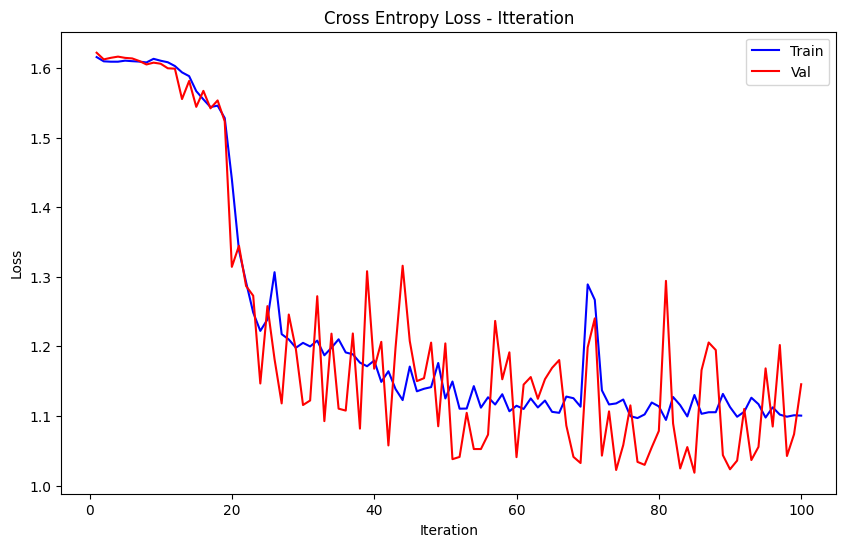

In [17]:
plt.figure(figsize=(10, 6))
plt.title("Cross Entropy Loss - Itteration")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(1, epochs+1), train_loss_array, color='blue', label='Train')
plt.plot(range(1, epochs+1), val_loss_array, color='red', label='Val')
plt.legend()
plt.show()

# Test

In [18]:
test_loss = 0.0
accuracy_array = []

for data, label in test_loader:
    data, label = data.to(device), label.to(device)
    
    label_pred = model(data)
    y = torch.argmax(label_pred, dim=1)
    t = torch.argmax(label, dim=1)

    accuracy_array.extend(y == t)

    loss = criterion(label_pred, label)
    test_loss += loss.item()

test_loss = test_loss / len(val_loader)

accuracy_array = torch.stack(accuracy_array)

torch.cuda.empty_cache()

print(f"Loss: {test_loss:.5f}")
print(f"Accuracy: {accuracy_array.sum().item() / accuracy_array.shape[0]:.3f}")

Loss: 1.40040
Accuracy: 0.523
